In [1]:
!date

Thu May 22 02:21:06 PM EDT 2025


In [2]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

In [3]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ants
import pickle
from tqdm import tqdm
import seaborn as sns

In [4]:
def correlate_columns(arr1, arr2):
    """
    Computes the Pearson correlation between corresponding columns of two matrices.
    
    Parameters:
    arr1 (np.ndarray): First matrix of shape (370, 1000)
    arr2 (np.ndarray): Second matrix of shape (370, 1000)
    
    Returns:
    np.ndarray: 1D array of correlations for each column (size 1000)
    """
    # Ensure input arrays are numpy arrays
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    
    # Subtract the mean of each column (normalize)
    arr1_centered = arr1 - np.mean(arr1, axis=0)
    arr2_centered = arr2 - np.mean(arr2, axis=0)
    
    # Compute the numerator (covariance)
    numerator = np.sum(arr1_centered * arr2_centered, axis=0)
    
    # Compute the denominator (product of standard deviations)
    denominator = np.sqrt(np.sum(arr1_centered**2, axis=0) * np.sum(arr2_centered**2, axis=0))
    
    # Compute the Pearson correlation for each column
    correlation = numerator / denominator
    
    return correlation

In [5]:
def load_pickle(fn):
    if os.path.exists(fn):
        with open(fn, 'rb') as file:
            loaded_dict = pickle.load(file)
    return loaded_dict

In [91]:
def get_contrast_val(Y,return_type='contrast'):
    from nilearn.glm.first_level import make_first_level_design_matrix
    events_fn = '../Data/011-ABCD-events/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_events.tsv'
    events = pd.read_csv(events_fn.format(sub=subs[s],r=r),delimiter='\t')

    t_r = 0.8
    #n_scans = 370  # the acquisition comprises 128 scans
    n_scans = Y.shape[1]
    frame_times = (np.arange(n_scans) * t_r)

    X1 = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #

    Y = (Y-Y.mean(axis=1)[:,np.newaxis])/Y.std(axis=1)[:,np.newaxis] # Z score values
    Y = Y.transpose()
    X = X1.values
    beta = np.linalg.inv(X.T @ X1) @ X1.T @ Y
    beta = beta.T
    beta = beta.values

    contrast_vector = np.array([1,1,-3,1,1,1,-3,1,0,0,0,0,0,0]) # Faces > Place
    contrast_values = beta @ contrast_vector

    if return_type=='contrast':
        return contrast_values.mean()
    elif return_type=='betas':
        return beta.mean(axis=0)

In [7]:
indir = '../Data/020-fmriprepped'
subs = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
subs.sort()
print(len(subs))

34


In [8]:
#epi_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','func',f'{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz')
# conf_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','func',f'{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_desc-confounds_timeseries.tsv')
# events_fn = os.path.join(f'../Data/011-ABCD-events/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_events.tsv')
# ffa_im = ants.image_read('../Misc/ffa_mask_resampled.nii')

<AxesSubplot:>

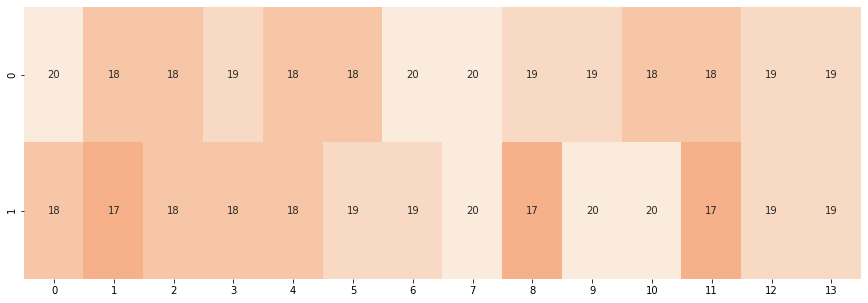

In [9]:
output_fn_temp = '../Data/StudyForrest/ensembles_last_CVAE/DeepCor-ABCD-v5/outputs_S{s}_R{r}_rep_{rep}.pickle'
done_check = np.zeros((14,2,20))
for s in range(14):
    for r in [1,2]:
        for rep in range(20):
            done_check[s,r-1,rep] = os.path.exists(output_fn_temp.format(s=s,r=r,rep=rep))
plt.figure(figsize=(15,5))
sns.heatmap(done_check.sum(axis=-1).transpose(),annot=True,vmin=0,vmax=20,cbar=False)

In [42]:
def get_data(s,r):
    sub_pickles = [load_pickle(output_fn_temp.format(s=s,r=r,rep=rep)) for rep in range(20) if os.path.exists(output_fn_temp.format(s=s,r=r,rep=rep))]

    sub_signals = np.array([val['signal'] for val in sub_pickles])
    #sub_signal_avg = np.average(sub_signals,axis=0)
    has_nans = np.isnan(sub_signals).sum(axis=-1).sum(axis=-1)!=0
    has_nans+=sub_signals.max(axis=-1).max(axis=-1)>1e3
    has_nans+=sub_signals.max(axis=-1).max(axis=-1)<1e-3
    sub_signal_avg = np.average(sub_signals[~has_nans,:,:],axis=0)
    sub_ffa = sub_pickles[0]['ffa']
    sub_compcor = sub_pickles[0]['ffa_compcorr']
    sub_face_reg = sub_pickles[0]['face_reg'] 
    sub_place_reg = sub_pickles[0]['place_reg'] 
    sub_conf = sub_pickles[0]['confounds']

    v_idx = sub_signal_avg.std(axis=-1)>1e-3
    n_vox = sum(v_idx)

    r_signal = correlate_columns(sub_signal_avg[v_idx,:].transpose(),np.array([sub_face_reg for _ in range(n_vox)]).transpose()).mean()
    r_ffa = correlate_columns(sub_ffa[v_idx,:].transpose(),np.array([sub_face_reg for _ in range(n_vox)]).transpose()).mean()
    r_compcor = correlate_columns(sub_compcor[v_idx,:].transpose(),np.array([sub_face_reg for _ in range(n_vox)]).transpose()).mean()

    con_signal = get_contrast_val(sub_signal_avg[v_idx,:],return_type='contrast')
    con_ffa = get_contrast_val(sub_ffa[v_idx,:],return_type='contrast')
    con_compcor = get_contrast_val(sub_compcor[v_idx,:],return_type='contrast')
    
    return [r_ffa,r_compcor,r_signal,con_ffa,con_compcor,con_signal]

In [41]:
s = 7
r = 1

sub_pickles = [load_pickle(output_fn_temp.format(s=s,r=r,rep=rep)) for rep in range(20) if os.path.exists(output_fn_temp.format(s=s,r=r,rep=rep))]

sub_signals = np.array([val['signal'] for val in sub_pickles])
#sub_signal_avg = np.average(sub_signals,axis=0)
has_nans = np.isnan(sub_signals).sum(axis=-1).sum(axis=-1)!=0
has_nans+=sub_signals.max(axis=-1).max(axis=-1)>1e3
sub_signal_avg = np.average(sub_signals[~has_nans,:,:],axis=0)
sub_ffa = sub_pickles[0]['ffa']
sub_compcor = sub_pickles[0]['ffa_compcorr']
sub_face_reg = sub_pickles[0]['face_reg'] 
sub_place_reg = sub_pickles[0]['place_reg'] 
sub_conf = sub_pickles[0]['confounds']

v_idx = sub_signal_avg.std(axis=-1)>1e-3
n_vox = sum(v_idx)

r_signal = correlate_columns(sub_signal_avg[v_idx,:].transpose(),np.array([sub_face_reg for _ in range(n_vox)]).transpose()).mean()
r_ffa = correlate_columns(sub_ffa[v_idx,:].transpose(),np.array([sub_face_reg for _ in range(n_vox)]).transpose()).mean()
r_compcor = correlate_columns(sub_compcor[v_idx,:].transpose(),np.array([sub_face_reg for _ in range(n_vox)]).transpose()).mean()

con_signal = get_contrast_val(sub_signal_avg[v_idx,:],return_type='contrast')
con_ffa = get_contrast_val(sub_ffa[v_idx,:],return_type='contrast')
con_compcor = get_contrast_val(sub_compcor[v_idx,:],return_type='contrast')

In [43]:
results = [[get_data(s,r) for r in [1,2]] for s in tqdm(range(len(subs)))]
results = np.array(results)


100%|██████████| 34/34 [00:26<00:00,  1.31it/s]


In [67]:
results_avg = results.mean(axis=0).mean(axis=0)

In [68]:
results_avg

array([0.09569928, 0.09393417, 0.13727317, 0.01406661, 0.13304559,
       0.06707546])

Text(0, 0.5, 'Correlation (r)')

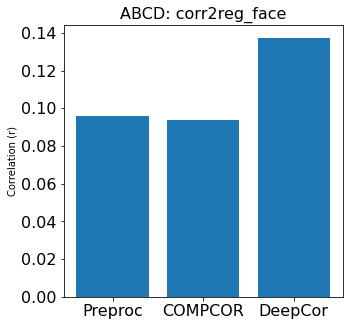

In [92]:
plt.figure(figsize=(5,5))
xs = [0,1,2]
plt.bar(xs,results_avg[0:3])
plt.xticks(xs,labels=['Preproc','COMPCOR','DeepCor'],fontsize=16)
plt.yticks(fontsize=16)
plt.title('ABCD: corr2reg_face',fontsize=16)
plt.ylabel('Correlation (r)')

In [93]:
results_avg[3::]

array([0.01406661, 0.13304559, 0.06707546])

Text(0.5, 1.0, 'corr2reg_face')

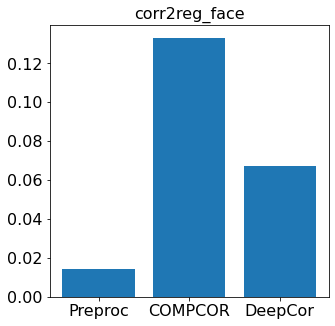

In [94]:
plt.figure(figsize=(5,5))
xs = [0,1,2]
plt.bar(xs,results_avg[3::])
plt.xticks(xs,labels=['Preproc','COMPCOR','DeepCor'],fontsize=16)
plt.yticks(fontsize=16)
plt.title('corr2reg_face',fontsize=16)

In [83]:
def plot_scatter(vec1,vec2,xlabel='',ylabel='',title=''):
    plt.scatter(vec1, vec2, color='blue', label='Data points',s=150)
    f = 20
    plt.xticks(fontsize=f)
    plt.yticks(fontsize=f)

    # Adding the parity line (where y = x)
    # Determine the limits for the line based on the data range:
    min_val = min(np.min(vec1), np.min(vec2))
    max_val = max(np.max(vec1), np.max(vec2))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Parity line (y=x)')

    # Add labels and title
    plt.xlabel(xlabel,fontsize=16,fontweight='bold')
    plt.ylabel(ylabel,fontsize=16,fontweight='bold')
    plt.title(title,fontsize=16,fontweight='bold')
    plt.grid(True)

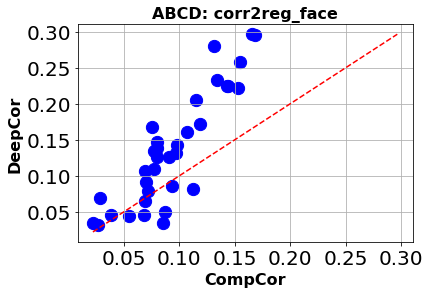

In [86]:
plot_scatter(results.mean(axis=1)[:,1],results.mean(axis=1)[:,2],xlabel='CompCor',ylabel='DeepCor',title='ABCD: corr2reg_face')

In [87]:
def pretty_t_test(vec1,vec2,ttl,alternative='two-sided'):
    from scipy.stats import ttest_rel
    t,p = ttest_rel(np.arctanh(vec1),np.arctanh(vec2),alternative=alternative) # Fisher Z transform before t-testing
    degf = len(vec1)-1
    diff = vec1.mean()-vec2.mean()

    if p < .001:
        print(f'{ttl} ΔM={diff:.3f}, t({int(degf)}) = {t:.2f}, p < .001')
    else:
        print(f'{ttl} ΔM={diff:.3f}, t({int(degf)}) = {t:.2f}, p = {p:.3f}')

In [78]:
pretty_t_test(results.mean(axis=1)[:,2],results.mean(axis=1)[:,0],ttl='DeepCor > Preprocessing ')

DeepCor > Preprocessing  ΔM=0.042, t(33) = 4.21, p < .001


In [79]:
pretty_t_test(results.mean(axis=1)[:,2],results.mean(axis=1)[:,1],ttl='DeepCor > CompCor ')

DeepCor > CompCor  ΔM=0.043, t(33) = 5.08, p < .001


In [64]:
# Test - retest relaibility
# 34 vec of beta values for run 1 and 2. 
# 
# 

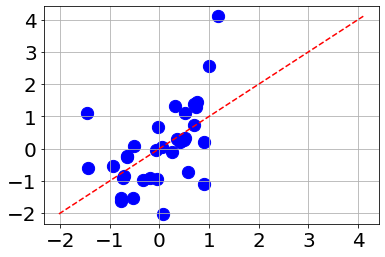

In [96]:
plot_scatter(results.mean(axis=1)[:,3],results.mean(axis=1)[:,5],xlabel='',ylabel='',title='')

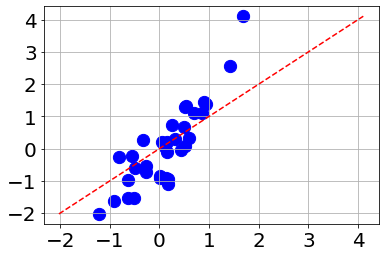

In [95]:
plot_scatter(results.mean(axis=1)[:,4],results.mean(axis=1)[:,5],xlabel='',ylabel='',title='')

In [ ]:
# dict_keys(['recon', 'recon_coords', 'signal', 'signal_coords', 'noise', 'noise_coords', 'ffa', 
#'ffa_coords', 'ffa_compcorr', 'face_reg', 'place_reg', 'confounds'])